In [1]:
import numpy as np 
import pandas as pd 
from numpy import array
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report 
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
data = pd.read_csv('/home/alaa/Desktop/Data_Analytics/Tweets.csv')

In [3]:
def remove_mentions(input_tweet):
    for i in range(len(input_tweet)):
        input_tweet[i] = re.sub(r'@\w+', '', input_tweet[i])
    return input_tweet

def remove_links(input_tweet):
    for i in range(len(input_tweet)):
        input_tweet[i] = re.sub(r'http\S+', '',input_tweet[i])
    return input_tweet

def remove_stopwords(input_tweet):
    list_of_stopwords = stopwords.words('english')
    #for sentiment analysis some stopwords might give an important indication ,for example: not no, so they should not be removed.
    important_stopwords = ["not", "no"]
    words = input_tweet.split()
    clean_stopwords = [word for word in words if (word not in list_of_stopwords or word in important_stopwords) and len(word) > 1]
    return " ".join(clean_stopwords)

def remove_punctuation(input_tweet):
    for i in range(len(input_tweet)):
        input_tweet[i] = re.sub(r'[^\w\s]','',input_tweet[i])
    return input_tweet

def lower_case(input_tweet):
    for i in range(len(input_tweet)):
        input_tweet[i] = input_tweet[i].lower()
    return input_tweet

In [4]:
data_new = data[['text', 'airline_sentiment']]
preprocessed_data = data_new.apply(remove_mentions).apply(remove_links).apply(remove_punctuation).apply(lower_case)
cleaned_tweets = []
for tweets in preprocessed_data.text:
    clean_stopwords = remove_stopwords(tweets)
    cleaned_tweets.append(clean_stopwords)

X = cleaned_tweets
Y = preprocessed_data['airline_sentiment']

Y = Y.map({'negative':0, 'positive':1, 'neutral':2}).astype(int)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=20)

In [6]:
def tf_idf(X_train,X_val,X_test):
  vectorizer = TfidfVectorizer(ngram_range=(1, 2))
  train_features = vectorizer.fit_transform(X_train) 
  val_features = vectorizer.transform(X_val)
  test_features = vectorizer.transform(X_test)
  return (train_features,val_features,test_features)

In [7]:
def results(labels, pred):
    print(confusion_matrix(labels,pred))  
    print(classification_report(labels,pred))  
    print(accuracy_score(labels, pred))

In [8]:
train_features,val_features,test_features=tf_idf(X_train,X_val,X_test)

In [9]:
clf = MultinomialNB()
clf.fit(train_features, y_train)

print ("Validation Accuracy of Naiive Bayes: %s"% ( accuracy_score(y_val, clf.predict(val_features))))

Validation Accuracy of Naiive Bayes: 0.6629464285714286


In [10]:
print ("Test Accuracy of Naiive Bayes: %s"% ( accuracy_score(y_test, clf.predict(test_features))))
results(y_test, clf.predict(test_features))

Test Accuracy of Naiive Bayes: 0.6730418943533698
[[1389    0    5]
 [ 307   50    5]
 [ 399    2   39]]
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      1394
           1       0.96      0.14      0.24       362
           2       0.80      0.09      0.16       440

    accuracy                           0.67      2196
   macro avg       0.81      0.41      0.40      2196
weighted avg       0.74      0.67      0.58      2196

0.6730418943533698


In [11]:
y_score=clf.predict(test_features)

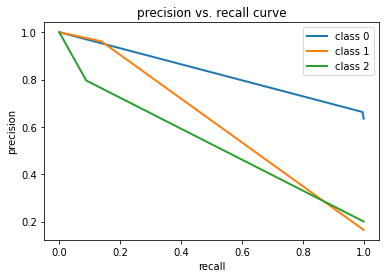

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# binarize the output
n_classes = 3
y_test = np.array(y_test)
y_test_b = label_binarize(y_test, classes=[*range(n_classes)])
y_score_b = label_binarize(y_score, classes=[*range(n_classes)])

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_b[:, i],
                                                        y_score_b[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

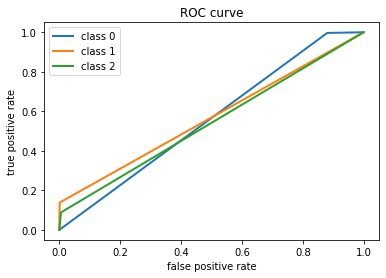

In [13]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i],
                                  y_score_b[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()